In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import bayesflow as bf
import tensorflow as tf

from functools import partial
from IPython.display import HTML
from bayesflow.simulation import Prior, Simulator, GenerativeModel

### Simulator

In [7]:
def initialize_agents(
        num_agents: int = 12,
        boundary_size: float = 10.0,
        rng=None
):
    if rng is None:
        rng = np.random.default_rng()

    positions = rng.uniform(size=(num_agents, 2)) * boundary_size
    directions = rng.uniform(size=num_agents) * 2 * np.pi

    return positions, directions


def simulator_fun(
    theta: np.array = None,
    num_agents: int = 12,
    num_timesteps: int = 100,
    boundary_size: float = 10.0,
    rng=None
):
    if rng is None:
        rng = np.random.default_rng()

    if theta is not None:
        radius, speed, eta = theta[0], theta[1], theta[2]
    else:
        radius, speed, eta = 0.1, 1.0, 0.1

    trajectories = np.zeros((num_timesteps + 1, num_agents, 2))
    headings = np.zeros((num_timesteps + 1, num_agents, 1))

    positions, directions = initialize_agents(num_agents, boundary_size, rng)
    trajectories[0] = positions
    headings[0] = directions[:, np.newaxis]

    for t in range(num_timesteps):
        new_directions = np.zeros(num_agents)
        for i in range(num_agents):
            neighbors = []
            for j in range(num_agents):
                if i != j and np.linalg.norm(positions[i] - positions[j]) < radius:
                    neighbors.append(directions[j])
            if neighbors:
                avg_direction = np.arctan2(np.mean(np.sin(neighbors)), np.mean(np.cos(neighbors)))
                new_directions[i] = avg_direction + rng.uniform(-eta * 0.5, eta * 0.5)
            else:
                new_directions[i] = directions[i]

        directions = new_directions
        positions[:, 0] += speed * np.cos(directions)
        positions[:, 1] += speed * np.sin(directions)
        positions = np.mod(positions, boundary_size)

        trajectories[t + 1] = positions
        headings[t + 1] = directions[:, np.newaxis]

    return np.concatenate((trajectories, headings), axis=-1, dtype=np.float32)

Making sure that it works.

In [12]:
test_path = simulator_fun()
test_path[0,0,:]

array([6.8637066, 2.345882 , 2.0218925], dtype=float32)

### Non-hierarchical priors

\begin{align}
    r &\sim \mathrm{Gamma}(2, 2),\\
    v &\sim \mathrm{Gamma}(0.5, 1),\\
    \eta &\sim \mathcal{U}(0, \pi).
\end{align}

In [9]:
def prior_fun(rng=None):
    
    if rng is None:
        rng = np.random.default_rng()
        
    r = rng.gamma(2,2)
    v = rng.gamma(0.5,1)
    eta = rng.uniform(0, np.pi)
    
    return np.array([r, v, eta], dtype=np.float32)

Again, making sure that it works.

In [10]:
test_prior = prior_fun()
test_prior

array([7.5907383, 0.6415941, 1.9887129], dtype=float32)

### Generative Model

In [14]:
param_names = [r'$r$', r'$v$', r'$\eta$']

In [15]:
prior = Prior(prior_fun=prior_fun, param_names=param_names)

In [16]:
simulator = Simulator(simulator_fun=simulator_fun)

In [17]:
model = GenerativeModel(prior=prior, simulator=simulator, simulator_is_batched=False)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 101, 12, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


### Configurator

In [18]:
def configurator(input_dict: dict = None, time_embedding: bool = False):
    output_dict = {}

    theta = input_dict['prior_draws']
    output_dict['parameters'] = theta

    x = input_dict['sim_data']

    # add time encoding to the data x
    if time_embedding:
        batch_size, num_timesteps, num_agents, _ = x.shape
        time_encoding = np.linspace(0, 1, num_timesteps)
        time_encoding_batched = np.tile(
            time_encoding[np.newaxis, :, np.newaxis, np.newaxis], 
            (batch_size, 1, num_agents, 1)
        )
        
    x1 = np.swapaxes(x, 2, 1)
    

    output_dict['summary_conditions'] = x1

    return output_dict

In [99]:
# Test a simulation
test_sim = model(10)
test_sim['sim_data'].shape

(10, 101, 12, 3)

In [20]:
out = configurator(test_sim)
out['summary_conditions'].shape

(10, 12, 101, 3)

### Neural approximator

In [114]:
# As advised, use SetTransformer in place of DeepSet
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.GRU(units=128)),
    bf.networks.SetTransformer(input_dim=128, summary_dim=64)
])

In [107]:
inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=3, 
    num_coupling_layers=6,
    coupling_settings={
        'kernel_regularizer': tf.keras.regularizers.l2(1e-4),
        'dropout_prob': 0.10
    }
)

In [115]:
amortizer = bf.amortizers.AmortizedPosterior(summary_net=summary_net, inference_net=inference_net)

In [116]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [117]:
amortizer.summary()

Model: "amortized_posterior_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network_15 (Inv  multiple                  605292    
 ertibleNetwork)                                                 
                                                                 
 hierarchical_network_4 (Hi  multiple                  468736    
 erarchicalNetwork)                                              
                                                                 
Total params: 1074028 (4.10 MB)
Trainable params: 1073992 (4.10 MB)
Non-trainable params: 36 (144.00 Byte)
_________________________________________________________________


Simulate data for training

In [118]:
simulation = model(5000)

In [119]:
history = trainer.train_offline(simulation, epochs=100, batch_size=1024, validation_sims=model(200))

Training epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 11.053


Training epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 5.646


Training epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 5.046


Training epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 4.787


Training epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 4.666


Training epoch 6:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 4.636


Training epoch 7:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 4.651


Training epoch 8:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 4.624


Training epoch 9:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 4.605


Training epoch 10:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 4.603


Training epoch 11:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 4.599


Training epoch 12:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 4.543


Training epoch 13:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 4.477


Training epoch 14:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 4.298


Training epoch 15:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 3.959


Training epoch 16:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 4.036


Training epoch 17:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 3.588


Training epoch 18:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 3.420


Training epoch 19:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 3.474


Training epoch 20:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 3.293


Training epoch 21:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 3.351


Training epoch 22:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 3.161


Training epoch 23:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 2.971


Training epoch 24:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 2.967


Training epoch 25:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 2.911


Training epoch 26:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 2.692


Training epoch 27:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 2.535


Training epoch 28:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: 2.476


Training epoch 29:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 2.428


Training epoch 30:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 2.406


Training epoch 31:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: 2.386


Training epoch 32:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: 2.247


Training epoch 33:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: 2.262


Training epoch 34:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: 2.235


Training epoch 35:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: 2.145


Training epoch 36:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: 2.181


Training epoch 37:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: 2.070


Training epoch 38:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: 2.044


Training epoch 39:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: 1.972


Training epoch 40:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: 1.944


Training epoch 41:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: 1.949


Training epoch 42:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: 1.911


Training epoch 43:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: 1.908


Training epoch 44:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: 1.867


Training epoch 45:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: 1.827


Training epoch 46:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: 1.821


Training epoch 47:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: 1.783


Training epoch 48:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: 1.732


Training epoch 49:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: 1.743


Training epoch 50:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: 1.720


Training epoch 51:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Loss: 1.679


Training epoch 52:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Loss: 1.649


Training epoch 53:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Loss: 1.688


Training epoch 54:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Loss: 1.653


Training epoch 55:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Loss: 1.646


Training epoch 56:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Loss: 1.580


Training epoch 57:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Loss: 1.596


Training epoch 58:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Loss: 1.568


Training epoch 59:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Loss: 1.522


Training epoch 60:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Loss: 1.527


Training epoch 61:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, Loss: 1.472


Training epoch 62:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, Loss: 1.440


Training epoch 63:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, Loss: 1.413


Training epoch 64:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, Loss: 1.420


Training epoch 65:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, Loss: 1.455


Training epoch 66:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, Loss: 1.394


Training epoch 67:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, Loss: 1.395


Training epoch 68:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, Loss: 1.337


Training epoch 69:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, Loss: 1.431


Training epoch 70:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, Loss: 1.554


Training epoch 71:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 71, Loss: 1.552


Training epoch 72:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 72, Loss: 1.341


Training epoch 73:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 73, Loss: 1.401


Training epoch 74:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 74, Loss: 1.311


Training epoch 75:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 75, Loss: 1.317


Training epoch 76:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 76, Loss: 1.333


Training epoch 77:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 77, Loss: 1.291


Training epoch 78:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 78, Loss: 1.285


Training epoch 79:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 79, Loss: 1.278


Training epoch 80:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 80, Loss: 1.261


Training epoch 81:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 81, Loss: 1.272


Training epoch 82:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 82, Loss: 1.262


Training epoch 83:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 83, Loss: 1.260


Training epoch 84:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 84, Loss: 1.250


Training epoch 85:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 85, Loss: 1.259


Training epoch 86:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 86, Loss: 1.245


Training epoch 87:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 87, Loss: 1.244


Training epoch 88:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 88, Loss: 1.219


Training epoch 89:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 89, Loss: 1.223


Training epoch 90:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 90, Loss: 1.214


Training epoch 91:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 91, Loss: 1.214


Training epoch 92:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 92, Loss: 1.210


Training epoch 93:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 93, Loss: 1.208


Training epoch 94:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 94, Loss: 1.210


Training epoch 95:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 95, Loss: 1.207


Training epoch 96:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 96, Loss: 1.205


Training epoch 97:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 97, Loss: 1.205


Training epoch 98:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 98, Loss: 1.204


Training epoch 99:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 99, Loss: 1.204


Training epoch 100:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 100, Loss: 1.204


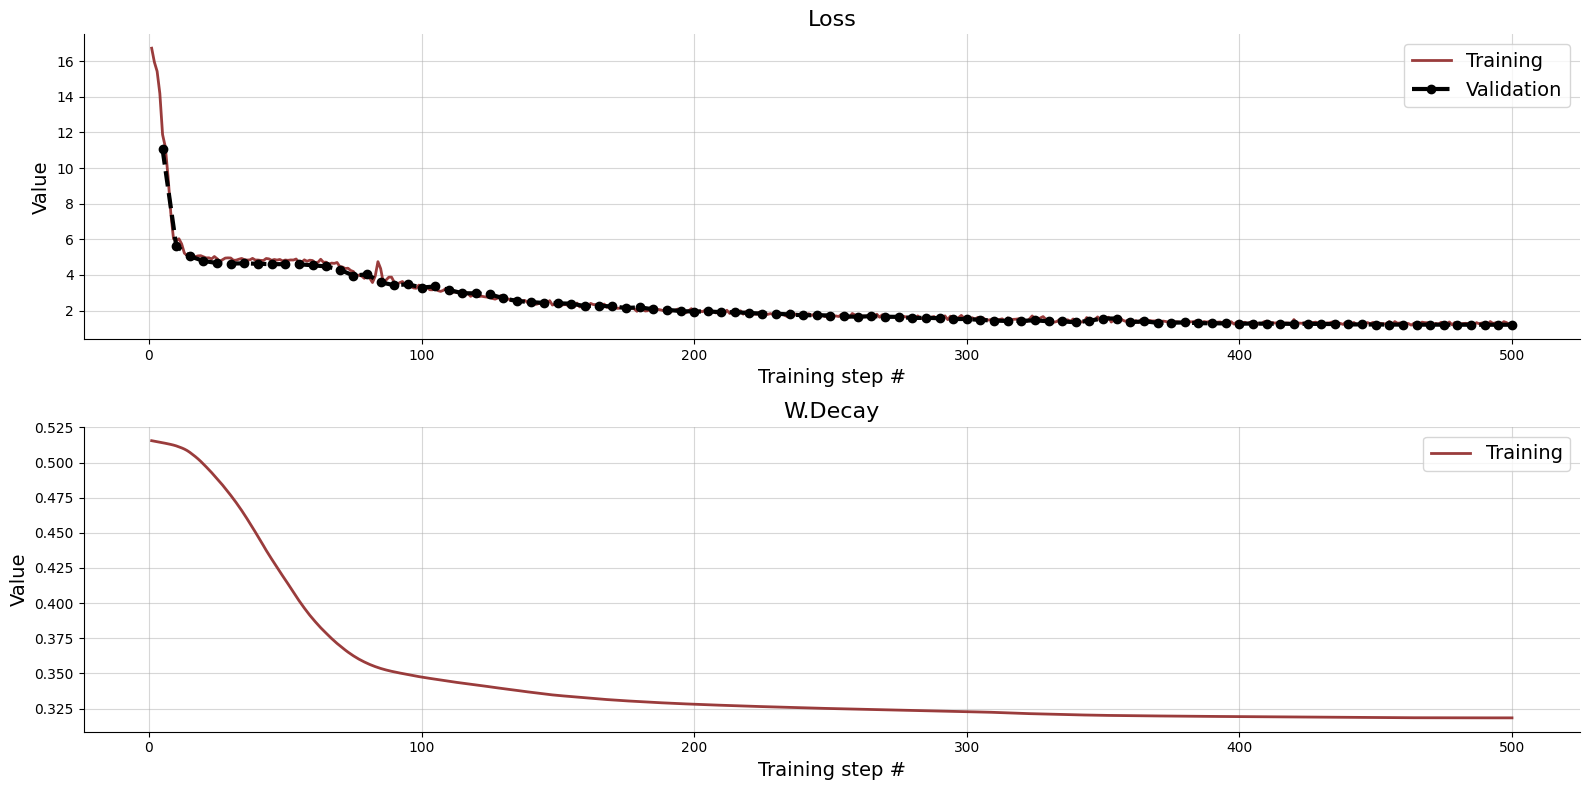

In [121]:
f = bf.diagnostics.plot_losses(history['train_losses'], history['val_losses'])

### Validation

In [122]:
validation_sim = model(200)

In [123]:
validation_sim = configurator(validation_sim)

In [124]:
post_samples = amortizer.sample(validation_sim, n_samples=1000)
post_samples.shape

(200, 1000, 3)

In [125]:
prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=10000)
prior_stds

array([[2.7515554 , 0.6910384 , 0.90531117]], dtype=float32)

In [126]:
prior_samples = validation_sim["parameters"] * prior_stds + prior_means

Parameter Recovery

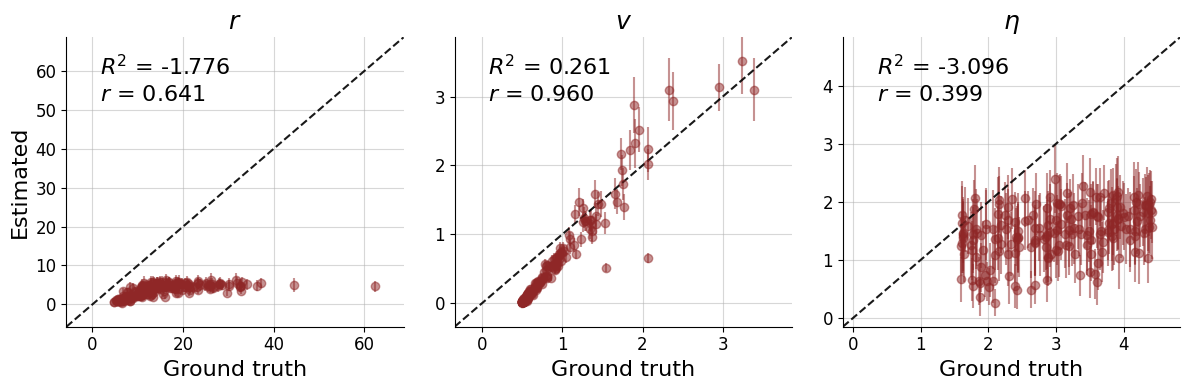

In [127]:
g = bf.diagnostics.plot_recovery(post_samples, prior_samples=prior_samples, param_names=param_names)

Simulation-based calibration

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


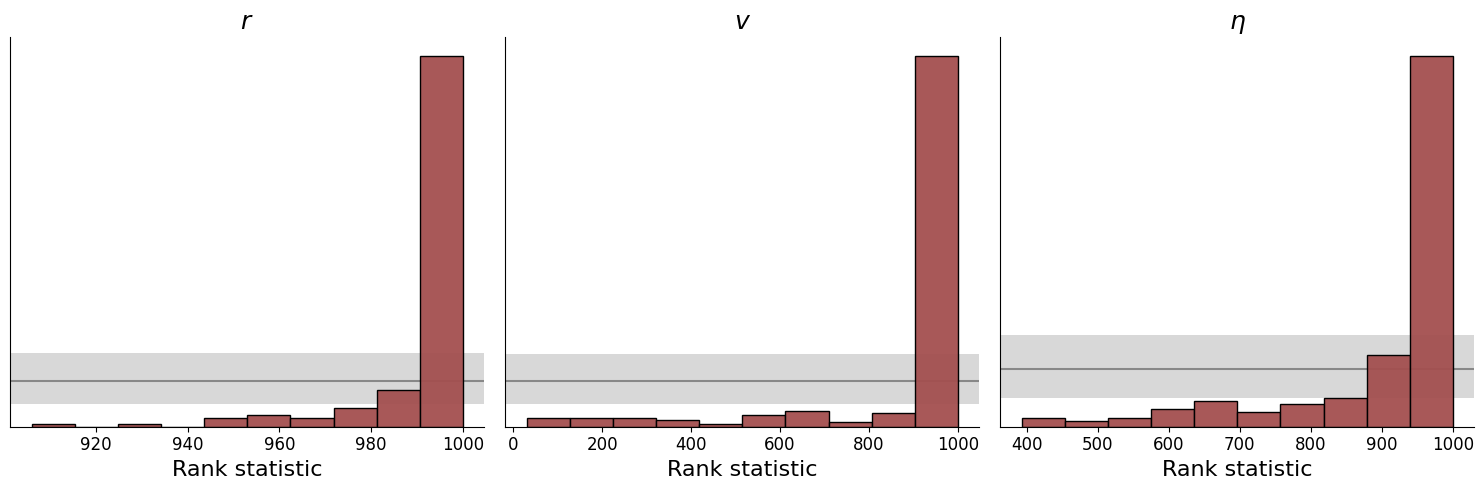

In [130]:
h = bf.diagnostics.plot_sbc_histograms(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names, num_bins=10)

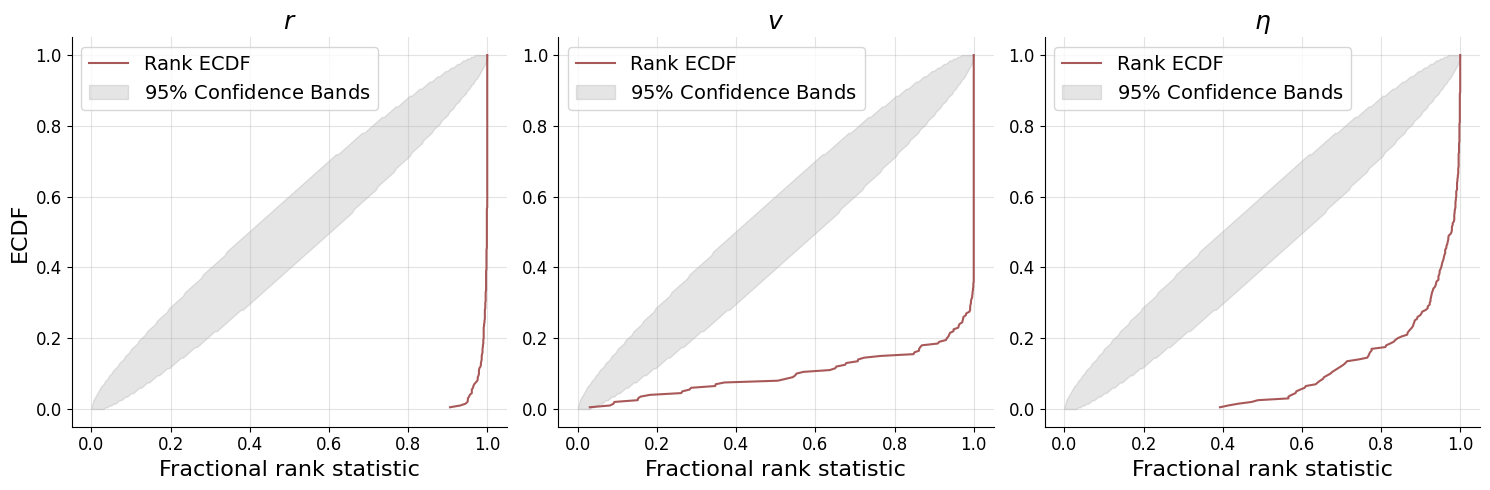

In [132]:
e = bf.diagnostics.plot_sbc_ecdf(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

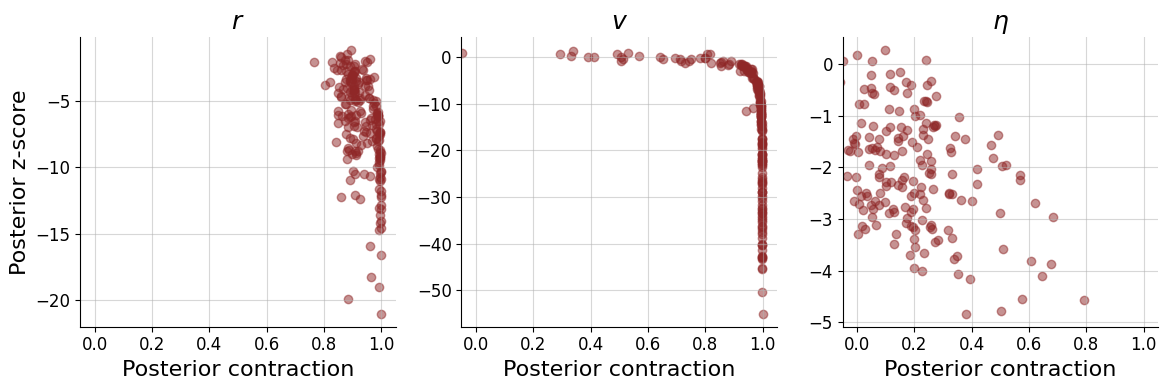

In [133]:
c = bf.diagnostics.plot_z_score_contraction(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

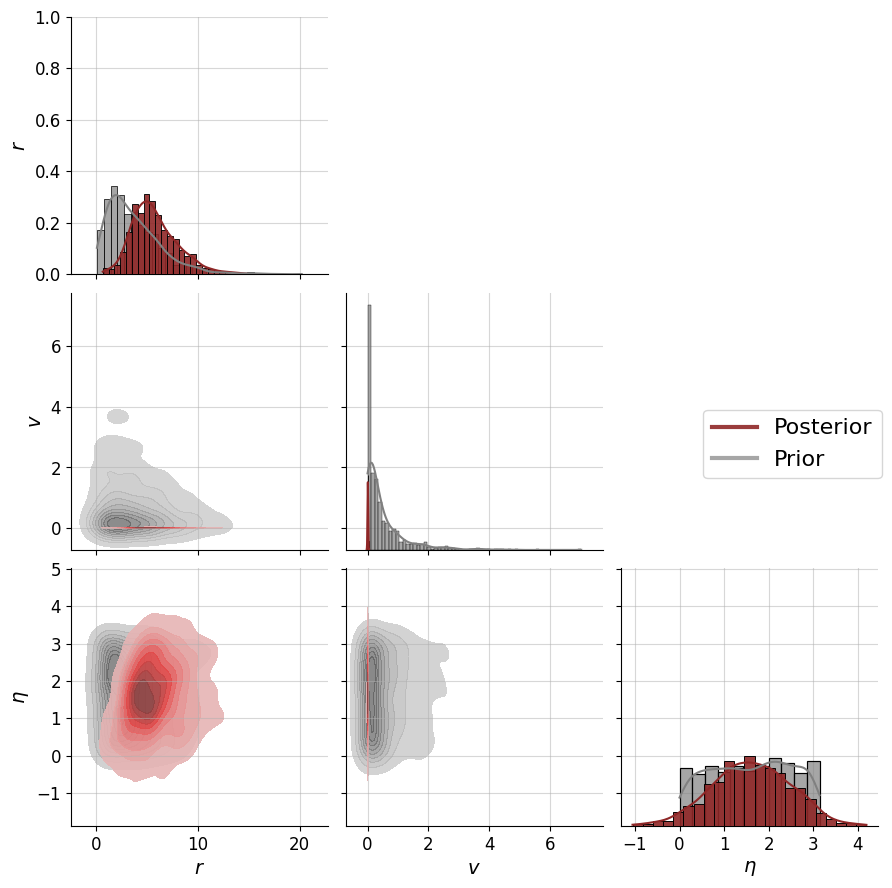

In [134]:
d = bf.diagnostics.plot_posterior_2d(posterior_draws=post_samples[0], prior=prior, param_names=param_names)